# Breast Cancer Detection Classifiers Trained on UCI Breast Cancer Wisconsin Diagnostic Dataset

The purpose of this project is to explore different classifiers trained on breast cancer diagnostic data to understand the comparative strengths and weaknesses of each model. Models will be assessed on a number of performance metrics such as accuracy, precision, recall and f1 score as well as interpretability and training time. We will additionally explore hyperparameter selection for each model.

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [59]:
from ucimlrepo import fetch_ucirepo
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets.values.ravel()

# metadata
# print(breast_cancer_wisconsin_diagnostic.metadata)
# Diagnosis (M = malignant, B = benign)
  
# variable information 
# print(breast_cancer_wisconsin_diagnostic.variables) 

In [60]:
def evaluate_model(y_test, y_pred):
    eval = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, target_names=np.array(['malignant', 'benign'], dtype='<U9'))
    }
    return eval

def print_eval_report(eval):
    print('Accuracy: ', round(eval['accuracy'], 3))
    print('Precision: ', round(eval['precision'], 3))
    print('Recall: ', round(eval['recall']))
    print('F1 Score: ', round(eval['f1_score'], 3))
    print('\nConfusion Matrix:\n ', eval['confusion_matrix'])
    print('\nClassification Report:\n ', eval['classification_report'])

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

scaler = StandardScaler()
le = LabelEncoder()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

## Logistic Regression

We'll begin with a logistic regression model. This model provides a linear boundary which minimizes the logistic loss function $\sum_{k=1}^N -y_k \ln p(x_k) - (1-y_k)\ln(1 - p(x_k))$ for $p(x_1,...,x_n) = (1 + \exp(-(\beta_0 + \beta_1 x_1 + ... + \beta_n x_n)))$. Additionally to help with overfitting we include an $\ell_2$ penalty term $1/C \sum_{i = 0}^n \beta_i^2$. The parameter $C$ will be selected by training and evaluating with multiple values.

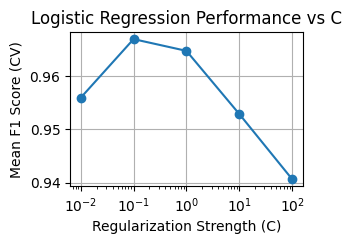

In [62]:
lr_param_grid = {
    'C' : [0.01, 0.1, 1, 10, 100],
    'penalty' : ['l2'],
    'solver' : ['liblinear'],
    'max_iter' : [1000]
}

lr_grid = GridSearchCV(LogisticRegression(), lr_param_grid, cv=5, scoring='f1')
lr_grid.fit(X_train_scaled, y_train)

lr_param_results = pd.DataFrame(lr_grid.cv_results_)
lr_scores = lr_param_results['mean_test_score']

plt.figure(figsize=(3,2))
plt.plot(lr_param_grid['C'], lr_scores, marker='o')
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Mean F1 Score (CV)')
plt.title('Logistic Regression Performance vs C')
plt.grid(True)
plt.show()

In [63]:
lr_model = LogisticRegression(
    C = 0.1,
    penalty = 'l2',
    solver = 'liblinear',
    max_iter = 1000
)

lr_start = time.time()
lr_model.fit(X_train_scaled, y_train)
lr_end = time.time()
lr_training_time = lr_end - lr_start

In [64]:
lr_y_pred = lr_model.predict(X_test_scaled)
lr_eval = evaluate_model(y_test, lr_y_pred)
print_eval_report(lr_eval)
print('Training time: ', lr_training_time, " seconds")

Accuracy:  0.956
Precision:  0.909
Recall:  1
F1 Score:  0.941

Confusion Matrix:
  [[69  4]
 [ 1 40]]

Classification Report:
                precision    recall  f1-score   support

   malignant       0.99      0.95      0.97        73
      benign       0.91      0.98      0.94        41

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

Training time:  0.001466989517211914  seconds


### Support Vector Machine

The next model we will train is an support vector machine classifier. Unlike logistic regression, SVM classifiers can support nonlinear decision boundaries depending on the choice of kernel, though they may take longer to train and be more prone to overfitting. Our PCA plot generated in the visualization section of this project suggests that a linear kernel will be sufficient for this dataset. 

While both SVM and logisitic regression produce linear decision boundaries, SVM maximizes the margin, i.e. distance from the boundary to the closest points. This provides better performance for datapoints near the boundary. Once again we will train and evaluate multiple values of $C$ to find the optimal parameter.

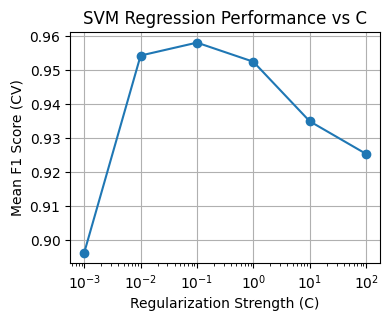

In [65]:
svm_param_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel' : ['linear']
}

svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=5, scoring='f1')
svm_grid.fit(X_train_scaled, y_train)

svm_param_results = pd.DataFrame(svm_grid.cv_results_)
svm_scores = svm_param_results['mean_test_score']

plt.figure(figsize=(4,3))
plt.plot(svm_param_grid['C'], svm_scores, marker='o')
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Mean F1 Score (CV)')
plt.title('SVM Regression Performance vs C')
plt.grid(True)
plt.show()

In [66]:
svm_model = SVC(kernel='linear', C=1.0, random_state=28)

svm_start = time.time()
svm_model.fit(X_train_scaled, y_train)
svm_end = time.time()
svm_training_time = svm_end - svm_start

In [67]:
svm_y_pred = svm_model.predict(X_test_scaled)
svm_eval = evaluate_model(y_test, svm_y_pred)
print_eval_report(svm_eval)
print('Training time: ', svm_training_time, " seconds")

Accuracy:  0.956
Precision:  0.909
Recall:  1
F1 Score:  0.941

Confusion Matrix:
  [[69  4]
 [ 1 40]]

Classification Report:
                precision    recall  f1-score   support

   malignant       0.99      0.95      0.97        73
      benign       0.91      0.98      0.94        41

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

Training time:  0.0025300979614257812  seconds


## Decision Tree and Random Forest

We will now turn to decision tree based models. Decision trees are highly interpretable models and can provide insight into the importance of features for classification. However they are very prone to overfitting, particularly for deep trees. To address this, we use Random Forest, an ensemble method that constructs many shallow trees from random subsets of the data and features.

First we will train a decision tree to gain information about the descriminatory power of each of our features and provide a baseline to compare to the ensemble method. Then we will train a random forest model using a grid search to optimize hyperparameters such as number of trees and maximum tree depth. While Random Forest is more computationally intensive than logistic regression or SVM, training time is not an issue for this dataset due to its manageable size. However, for larger datasets, constraints on the number of trees or tree depth may become necessary to ensure efficient training.

### Decision Tree

In [68]:
dt_model = DecisionTreeClassifier(random_state=28)
dt_model.fit(X_train, y_train)

dt_y_pred = dt_model.predict(X_test)
dt_eval = evaluate_model(y_test, dt_y_pred)
print_eval_report(dt_eval)

Accuracy:  0.895
Precision:  0.837
Recall:  1
F1 Score:  0.857

Confusion Matrix:
  [[66  7]
 [ 5 36]]

Classification Report:
                precision    recall  f1-score   support

   malignant       0.93      0.90      0.92        73
      benign       0.84      0.88      0.86        41

    accuracy                           0.89       114
   macro avg       0.88      0.89      0.89       114
weighted avg       0.90      0.89      0.90       114



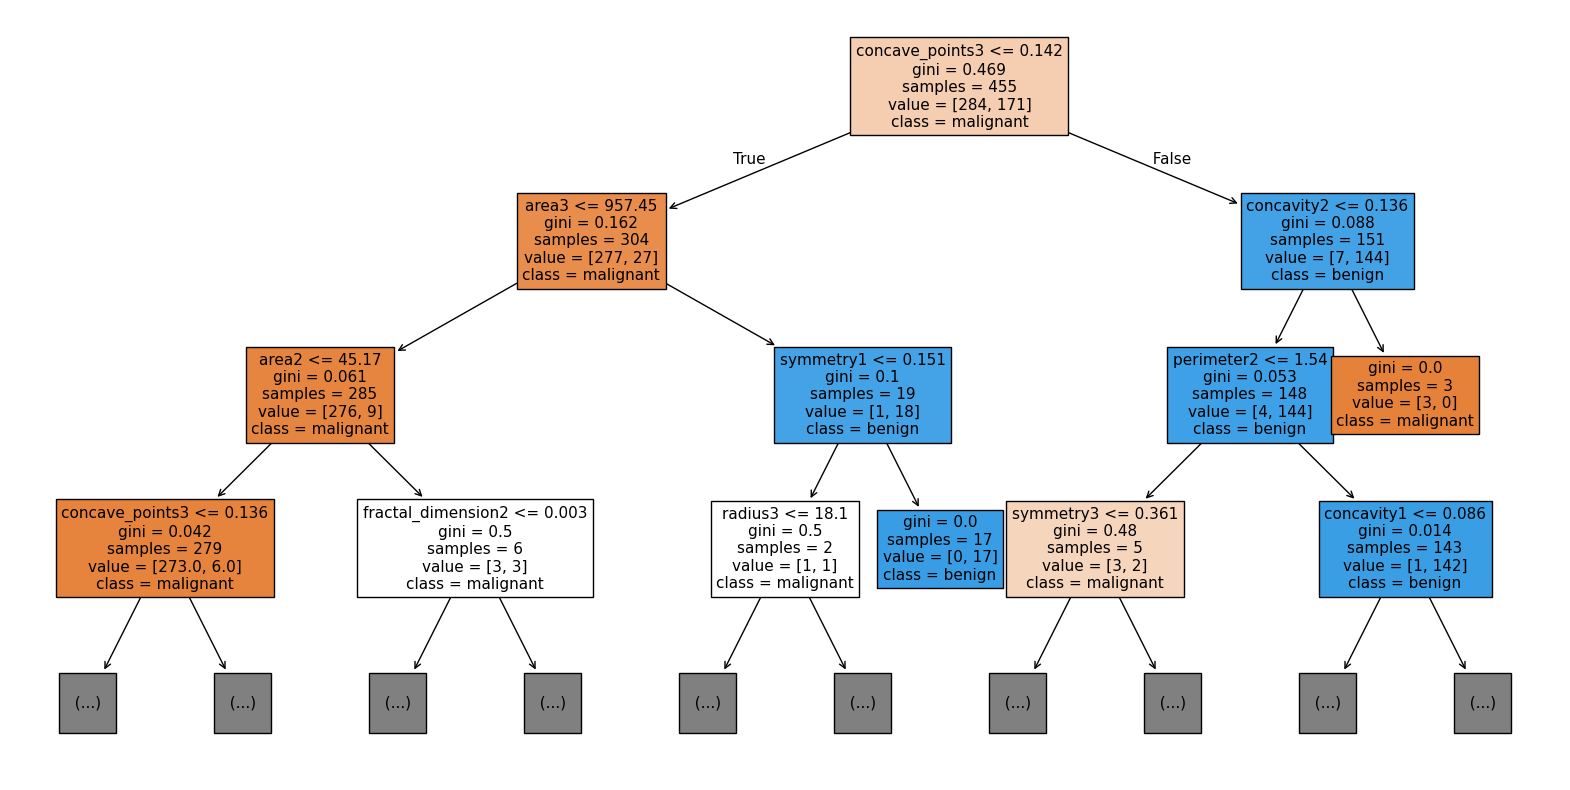

In [69]:
feature_names = X.columns

plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=feature_names, class_names=['malignant', 'benign'], fontsize=11, filled=True, max_depth=3)
plt.show()

From this decision tree we can see that the **concave points** worst value ("concave_points3") has the highest discriminatory power of all of the features, consistent with our observations from the histogram plots in the visualization section.

### Random Forest

In [70]:
rf_param_grid = {
    'n_estimators' : [100, 200, 300, 400, 500],
    'max_depth' : [None, 10, 20, 30]
}

rf_grid = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='f1')
rf_grid.fit(X_train, y_train)

print(rf_grid.best_params_)
print(rf_grid.best_score_)

{'max_depth': None, 'n_estimators': 100}
0.9622174840085288


In [71]:
rf_model = RandomForestClassifier(n_estimators=rf_grid.best_params_['n_estimators'], max_depth = rf_grid.best_params_['max_depth'], random_state=28)

rf_start = time.time()
rf_model.fit(X_train, y_train)
rf_end = time.time()
rf_training_time = rf_end - rf_start

In [72]:
rf_y_pred = rf_model.predict(X_test)
rf_eval = evaluate_model(y_test, rf_y_pred)
print_eval_report(rf_eval)
print('Training time: ', rf_training_time, " seconds")

Accuracy:  0.939
Precision:  0.905
Recall:  1
F1 Score:  0.916

Confusion Matrix:
  [[69  4]
 [ 3 38]]

Classification Report:
                precision    recall  f1-score   support

   malignant       0.96      0.95      0.95        73
      benign       0.90      0.93      0.92        41

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114

Training time:  0.08383011817932129  seconds


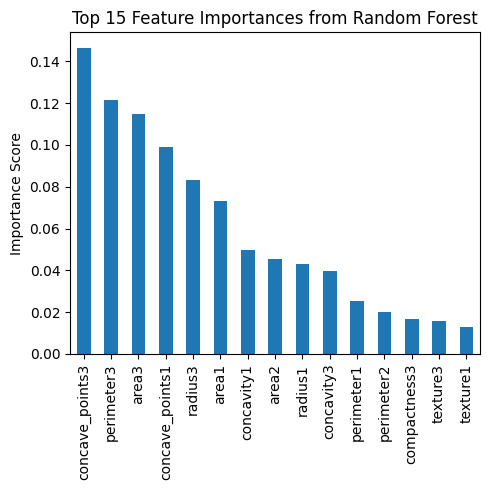

In [73]:
importances = rf_model.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

plt.figure(figsize=(5, 5))
feat_importances.head(15).plot(kind='bar')
plt.title('Top 15 Feature Importances from Random Forest')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

## Error Analysis

We will now compare the performance of the models across several evaluation metrics. Additionally we will examine specific instances where the models failed to better understand their performance.

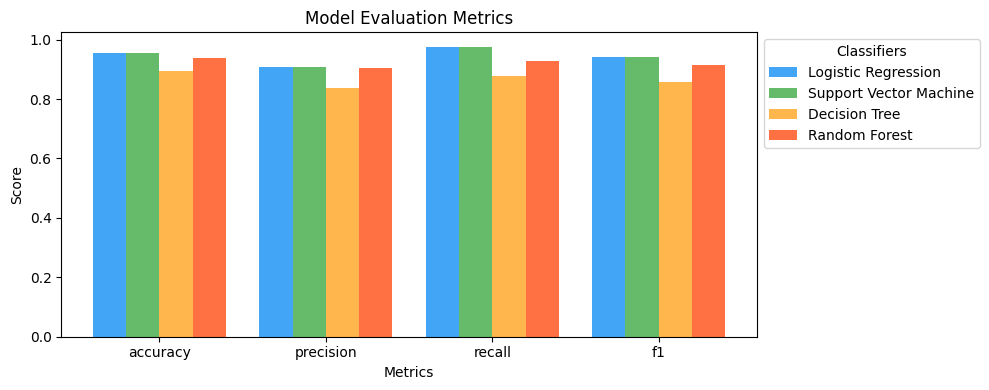

In [94]:
metrics = {
    'accuracy': [lr_eval['accuracy'], svm_eval['accuracy'], dt_eval['accuracy'], rf_eval['accuracy']],
    'precision': [lr_eval['precision'], svm_eval['precision'], dt_eval['precision'], rf_eval['precision']],
    'recall': [lr_eval['recall'], svm_eval['recall'], dt_eval['recall'], rf_eval['recall']],
    'f1': [lr_eval['f1_score'], svm_eval['f1_score'], dt_eval['f1_score'], rf_eval['f1_score']]
}

metric_names = ['accuracy', 'precision', 'recall', 'f1']
classifiers = ['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'Random Forest']

metric_values = np.array([metrics[name] for name in metric_names])

index = np.arange(len(metric_names))
bar_width = 0.2
colors = ['#42A5F5', '#66BB6A', '#FFB74D', '#FF7043']

fig, ax = plt.subplots(figsize=(10, 4))

for i, classifier in enumerate(classifiers):
    ax.bar(index + i * bar_width, metric_values[:, i], bar_width, label=classifier, color=colors[i])

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Evaluation Metrics')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(metric_names)

ax.legend(title='Classifiers', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

From this graph we can see that the linear models performed the best across all metrics. This is consistent with our observations in the data visualization section, where we concluded that a linear decision boundary was well suited for the data. Furthermore, we see that the Random Forest model outperformed the Decision Tree model on all metrics, which can be attributed to the Decision Tree's tendency to overfit the data.

Next we'll look at specific instances where the models were inaccurate.

In [76]:
print("Logistic Regression incorrect instances:")
print(np.where(lr_y_pred != y_test)[0])

print("Support Vector Machine incorrect instances:")
print(np.where(svm_y_pred != y_test)[0])

print("Decision Tree incorrect instances:")
print(np.where(dt_y_pred != y_test)[0])

print("Random Forest incorrect instances:")
print(np.where(rf_y_pred != y_test)[0])

Logistic Regression incorrect instances:
[13 23 50 72 92]
Support Vector Machine incorrect instances:
[13 23 50 54 72]
Decision Tree incorrect instances:
[ 1 13 17 19 23 29 49 50 54 59 71 76]
Random Forest incorrect instances:
[13 17 25 49 50 76 77]


In [141]:
all_model_error = [13, 50]
linear_model_error = [23, 54, 72, 92]
random_forest_model_error = [17, 25, 49, 76, 77]

In [131]:
def outlier(row):
    feature_average = row['error feature average']
    perc_25 = row['25%']
    perc_75 = row['75%']
    return perc_25 > feature_average or feature_average > perc_75

In [153]:
def outlier_analysis(indicies):
    X_train0 = X_train[~y_train.astype(bool)]
    X_train1 = X_train[y_train.astype(bool)]

    X_train0_stats = X_train0.describe().T
    X_train1_stats = X_train1.describe().T
    
    labels = y_test[indicies]

    means0 = X_test.iloc[indicies].loc[~labels.astype(bool)].mean()
    means1 = X_test.iloc[indicies].loc[labels.astype(bool)].mean()

    X_train0_stats['error feature average'] = means0
    X_train1_stats['error feature average'] = means1

    X_train0_stats['outlier'] = X_train0_stats.apply(outlier, axis=1)
    X_train1_stats['outlier'] = X_train1_stats.apply(outlier, axis=1)

    return (X_train0_stats[X_train0_stats['outlier']], X_train1_stats[X_train1_stats['outlier']])
    

In [154]:
print(outlier_analysis(all_model_error)[0].shape[0])
print(outlier_analysis(all_model_error)[1].shape[0])

18
23


In [166]:
print(outlier_analysis(linear_model_error)[0].shape[0])
print(outlier_analysis(linear_model_error)[1].shape[0])

X_test.iloc[linear_model_error].loc[y_test[linear_model_error].astype(bool)].shape[0]

19
0


0

In [156]:
print(outlier_analysis(random_forest_model_error)[0].shape[0])
print(outlier_analysis(random_forest_model_error)[1].shape[0])

19
14


We have focused on analyzing the error instances across the models, specifically linear models and Random Forest. For each set of error instances, we split them by class and examined the number of features where, on average, the data points are outliers in the class-conditional distribution of each feature within the training set. In this context, an "outlier" is defined as a point falling outside of the 25th to 75th percentile range.

The analysis shows that the points where both models failed are predictably outliers on most features. Specifically, 18 out of 30 features for those classified as "not having cancer" and 23 out of 30 features for those classified as "having cancer" are outliers. Notably, there are no instances classified as "having cancer" where the linear models alone failed.

For the instances where both linear models and Random Forest failed, the "non-cancer" points are outliers on 19 out of 30 features. On the other hand, the "cancer" failure points from Random Forest are outliers on 14 out of 30 features.

This outlier analysis suggests that the failure points are not particularly representative of the general distribution of the data. However, it is important to note that due to the small number of instances, this analysis has limited practical value.